# EDA for our Data

Imports

In [18]:
import csv, json
import geopandas as gpd
import pandas as pd
from scipy.stats import ttest_ind

from shapely.geometry import Point

import matplotlib.pyplot as plt
import seaborn as sns


Settings

In [2]:
pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid")

Loading Dataframes

In [8]:
stations = gpd.read_file("stationINFO.geojson")

crime = gpd.read_file("crime_with_weather.geojson")

bus_stops = gpd.read_file("Bus_Stops_With_Frequency_HLT.geojson")
ada = gpd.read_file("ADA_Signals.geojson")
schools = gpd.read_file("Schools_(points).geojson")
trees = gpd.read_file("LSM_Trees.geojson")

Sanity Checks Dataset

In [9]:
print(crime.geometry.type.value_counts())
print(stations.geometry.type.value_counts())
print(crime.geometry.type.value_counts)
print(trees.geometry.type.value_counts)
print(schools.geometry.type.value_counts)
print(ada.geometry.type.value_counts)
print(bus_stops.geometry.type.value_counts)

print(crime.crs)
print(stations.crs)
print(trees.crs)
print(schools.crs)
print(ada.crs)
print(bus_stops.crs)


Point    43754
Name: count, dtype: int64
Point    35
Name: count, dtype: int64
<bound method IndexOpsMixin.value_counts of 0        Point
1        Point
2        Point
3        Point
4        Point
         ...  
43749    Point
43750    Point
43751    Point
43752    Point
43753    Point
Length: 43754, dtype: str>
<bound method IndexOpsMixin.value_counts of 0         Point
1         Point
2         Point
3         Point
4         Point
          ...  
191287    Point
191288    Point
191289    Point
191290    Point
191291    Point
Length: 191292, dtype: str>
<bound method IndexOpsMixin.value_counts of 0      Point
1      Point
2      Point
3      Point
4      Point
       ...  
191    Point
192    Point
193    Point
194    Point
195    Point
Length: 196, dtype: str>
<bound method IndexOpsMixin.value_counts of 0       Point
1       Point
2       Point
3       Point
4       Point
        ...  
2768    Point
2769    Point
2770    Point
2771    Point
2772    Point
Length: 2773, dtype: str>
<

Crime

In [10]:
crime.head()
crime.columns
crime.describe(include="all")

,LOCATION,ZIP,CMPD_PATROL_DIVISION,NPA,DATE_INCIDENT_BEGAN,LOCATION_TYPE_DESCRIPTION,PLACE_TYPE_DESCRIPTION,PLACE_DETAIL_DESCRIPTION,HIGHEST_NIBRS_DESCRIPTION,cluster,cluster_title,geometry,index_right,name,lat,lon,tempmax,tempmin,temp,precip,precipcover,cloudcover,humidity,windspeed,visibility,snow,conditions
count,43754,43754.000000,43538,43754.000000,43754,43754,43754,43754,43754,43754.000000,43754,43754,43754.000000,43754,43754.000000,43754.000000,43754.000000,43754.000000,43754.000000,43754.000000,43754.000000,43754.000000,43754.000000,43754.000000,43754.000000,43754.000000,43754
unique,367,NaN,6,NaN,NaN,5,5,71,62,NaN,10,10,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
top,200 E TRADE ST,NaN,Central,NaN,NaN,Outdoors,Commercial Place,Street/Highway,All Other Thefts,NaN,"""Regulatory and Non-Violent Offenses""",POINT (-80.84 35.23),NaN,CTC/Arena,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Partially cloudy
freq,3612,NaN,42544,NaN,NaN,16606,18064,6541,6904,NaN,15204,20912,NaN,11196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21804
mean,NaN,28202.535677,NaN,428.169310,2021-07-23 17:41:52.940000,NaN,NaN,NaN,NaN,4.098597,NaN,NaN,2.687617,NaN,35.223558,-80.843431,73.366611,54.059069,63.449077,0.109660,7.995272,53.552377,65.978770,11.766675,9.181010,0.000990,NaN
min,NaN,28078.000000,NaN,0.000000,1973-05-24 00:00:00,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,35.211940,-80.859170,26.900000,9.000000,18.300000,0.000000,0.000000,0.000000,24.400000,4.300000,0.600000,0.000000,NaN
25%,NaN,28202.000000,NaN,476.000000,2019-02-28 00:00:00,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,35.223610,-80.843060,62.200000,41.900000,52.200000,0.000000,0.000000,32.600000,56.600000,8.800000,9.100000,0.000000,NaN
50%,NaN,28202.000000,NaN,476.000000,2021-10-13 00:00:00,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,2.000000,NaN,35.225000,-80.841390,75.100000,56.000000,65.600000,0.000000,0.000000,54.300000,66.900000,11.200000,9.700000,0.000000,NaN
75%,NaN,28202.000000,NaN,476.000000,2023-12-24 00:00:00,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,3.000000,NaN,35.227220,-80.838060,85.800000,67.900000,76.200000,0.042000,8.330000,74.200000,75.900000,14.100000,9.900000,0.000000,NaN
max,NaN,28278.000000,NaN,476.000000,2026-01-11 00:00:00,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,7.000000,NaN,35.229700,-80.835000,102.400000,78.900000,89.900000,4.192000,100.000000,100.000000,98.300000,42.300000,15.900000,1.200000,NaN


Feature Engineering

In [ ]:
crime["datetime"] = pd.to_datetime(crime["DATE_INCIDENT_BEGAN"])
crime["hour"] = crime["datetime"].dt.hour
crime["weekday"] = crime["datetime"].dt.weekday
crime["month"] = crime["datetime"].dt.month
crime["is_night"] = crime["hour"].between(19, 5)

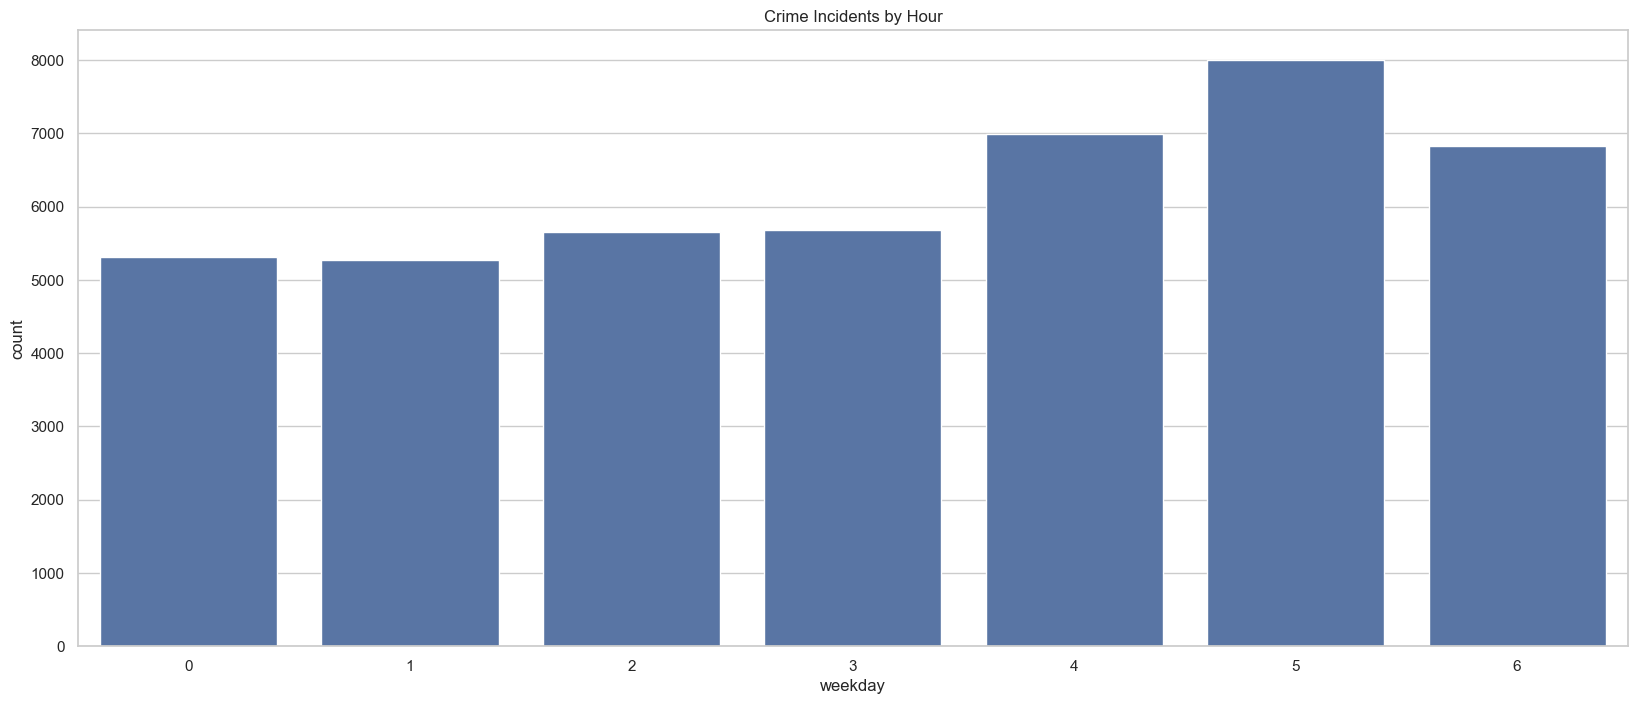

In [17]:
plt.figure(figsize=(20,8))
sns.countplot(x="weekday", data=crime)
plt.title("Crime Incidents by Hour")
plt.show()

Checking for statiscal difference in Saturday and Sunday

In [ ]:
#getting the oldest data points in our dataset
crime.sort_values("datetime").head(10)
#only getting data from june 2022 onwards
relavent_crime = crime[crime["datetime"] >= "2022-06-01"]

# filter weekend days
saturday = relavent_crime[relavent_crime['weekday'] == 5]
sunday   = relavent_crime[relavent_crime['weekday'] == 6]

# compute numeric metric: crimes per day (you can change to per-hour or other aggregation)
sat_counts = saturday.groupby(saturday['datetime'].dt.date).size().astype(float)
sun_counts = sunday.groupby(sunday['datetime'].dt.date).size().astype(float)

# align/drop NaNs if needed (grouping.size() won't create NaNs, but be explicit)
sat_counts = sat_counts.dropna()
sun_counts = sun_counts.dropna()

# two-sample t-test (Welch's t-test)
t_stat, p_value = ttest_ind(sat_counts, sun_counts, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")
# ...existing code...

T-statistic: 4.068615275776203, P-value: 5.7678159746669274e-05


No statistical difference found

Checking Weather Differences

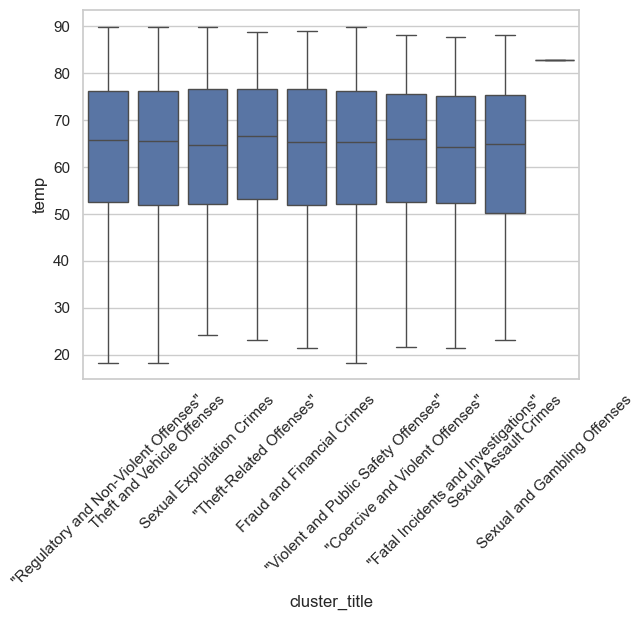

In [ ]:
#Temperature differences by crime cluster
sns.boxplot(x="cluster_title", y="temp", data=crime)
plt.xticks(rotation=45)
plt.show()


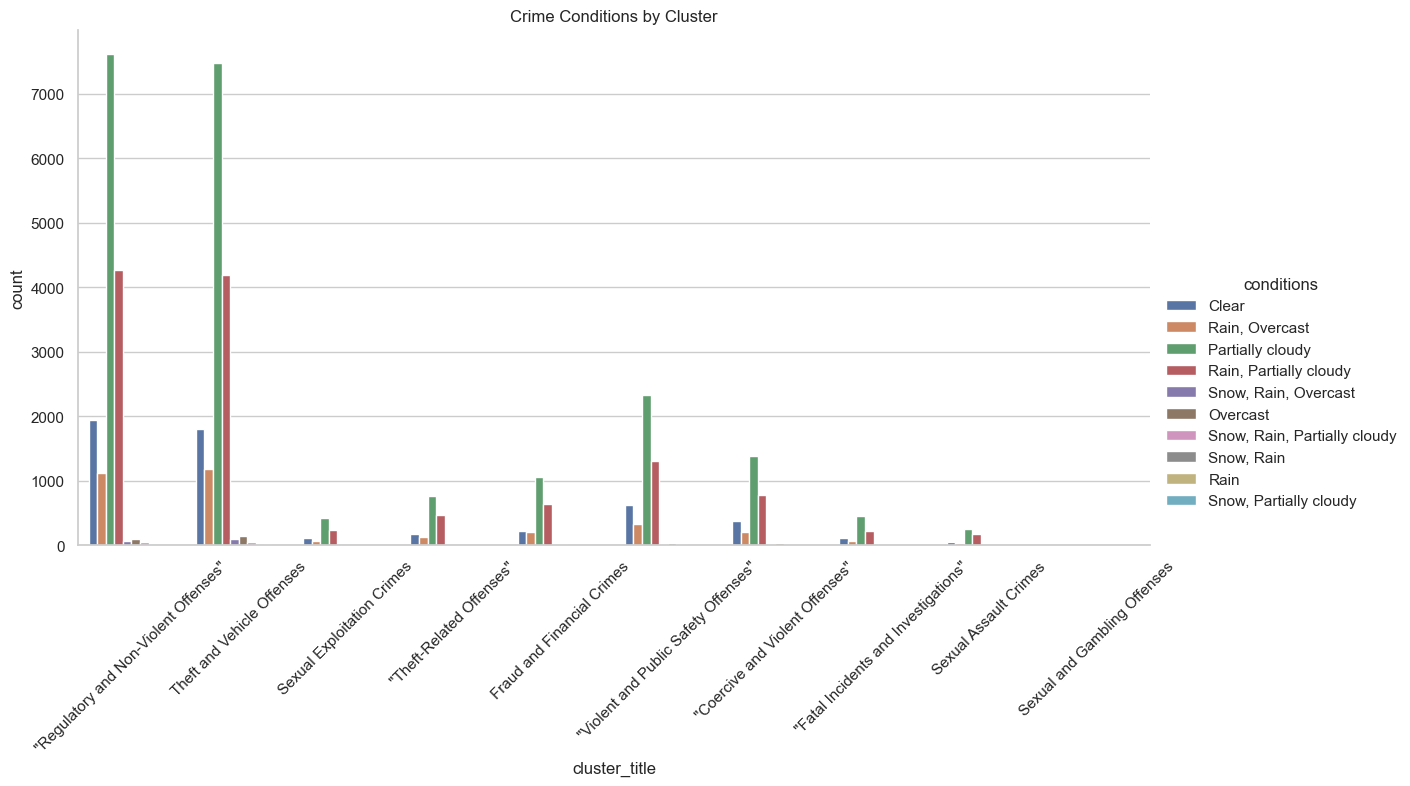

In [45]:
#Conditions differences by crime cluster by clustered bar chart
sns.catplot(x="cluster_title", hue="conditions", kind="count", data=crime, height=6, aspect=2)
plt.xticks(rotation=45)
plt.title("Crime Conditions by Cluster")
plt.show()